In [1]:
import xarray as xr
import numpy as np
import numpy.ma as ma
import xesmf as xe
import numpy as np
import matplotlib.pyplot as plt
from netCDF4 import Dataset, num2date
from datetime import datetime, timedelta, date
from metpy.units import units
import metpy.calc as mpcalc
from metpy.interpolate import interpolate_to_isosurface
from spharm import Spharmt, getspecindx
import derivative
import scipy
import wavebreakpy as rwb
import Ngl
# Mapping packages
import cartopy.util as cu
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.ticker as mticker
import calendar
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER


This cell includes the function that calculates potential vorticity, interpolates to the DT, and calculates variables on the DT. I would recommend using this for the MERRA2 data for now.

In [8]:
def calcPV(temperature,uwind,vwind,p_arr,lon,lat,interpolation_value,bottom_or_top,lat_select):
    '''
    Calculate the potential vorticity using the MetPy potential vorticity baroclinic function 
    The function requires Numpy arrays in the following order:
    Note: The level variable is assumed to start at the top of the atmosphere (zeroth index)
    Temperature (time x level x lat x lon)
    zonal (u) component of the wind (time x level x lat x lon)
    meridional (v) component of the wind (time x level x lat x lon)
    p_arr: 1-D Numpy array (level) of the pressure levels of the data 
    lon: Numpy array of the longitude values
    lat: Numpy array of the latitude values
    interpolation_value: The desired level of interpolation (e.g., 2 PVU = 2*10**-6)
    bottom_or_top: Whether a top-down or bottom up linear interpolation to the level of interest is desired 
    (1 is top-down, 0 is bottom-up)
    Returns:
    Potential temperature on the level of interest
    Pressure on the level of interest
    Temperature on the level of interest
    u-wind on the level of interest
    v-wind on the level of interest
    Potential temperature
    Potential vorticity
    '''
    # Grab the shape of the temperature data for creation of fields on the DT
    data_sh        = np.shape(temperature)
    DT_theta       = np.zeros((data_sh[0],data_sh[2],data_sh[3]))
    DT_temperature = np.zeros((data_sh[0],data_sh[2],data_sh[3]))
    DT_pressure    = np.zeros((data_sh[0],data_sh[2],data_sh[3]))
    DT_u_wind      = np.zeros((data_sh[0],data_sh[2],data_sh[3]))
    DT_v_wind      = np.zeros((data_sh[0],data_sh[2],data_sh[3]))
    PV             = np.zeros((data_sh[0],len(p_arr), data_sh[2], data_sh[3]))
    theta_arr      = np.zeros((data_sh[0],len(p_arr), data_sh[2], data_sh[3]))
    # Calculate potential vorticity using MetPy
    P_arr  = rwb.p2nd(p_arr,temperature,3)
    dx, dy = mpcalc.lat_lon_grid_deltas(lon,lat)
    lat_PV = lat*units.Quantity('degrees')
    # Insert a blank axis to make deltas appear as 3D for derivatives to work in MetPy function
    dx     = dx[None, :, :]
    dy     = dy[None, :, :] 
    lat_PV = lat_PV[None,:,None]
    # Ensure sign is correct for interpolation value (PVU)
    if lat_select == 'NH':
            if interp_val <= 0:
                interp_value = -interp_val
    elif lat_select == 'SH':
            if interp_val >= 0:
                interp_value = -interp_val
    # Complete PV calculation 
    for t in range(0,data_sh[0]):
        T_arr       = temperature[t]
        u_arr       = uwind[t]
        v_arr       = vwind[t]
        theta_arr[t]= mpcalc.potential_temperature(P_arr*units.hPa,units.Quantity(T_arr,'kelvin'))
        PV[t]       = mpcalc.potential_vorticity_baroclinic(theta_arr[t]*units.Quantity('kelvin'),P_arr*units.Quantity('hPa'),
                                                            u_arr*units.Quantity('m/s'),
                                                            v_arr*units.Quantity('m/s'),
                                                            dx=dx,dy=dy,latitude=lat_PV)
        # Interpolate to Dynamic Tropopause (2 PVU surface)
        DT_theta[t]       = interpolate_to_isosurface(np.array(PV[t]), np.array(theta_arr[t]), interp_val, b_or_t_search)
        DT_pressure[t]    = interpolate_to_isosurface(np.array(PV[t]), np.array(P_arr), interp_val, b_or_t_search)
        DT_temperature[t] = interpolate_to_isosurface(np.array(PV[t]), np.array(T_arr), interp_val, b_or_t_search)
        DT_u_wind[t]      = interpolate_to_isosurface(np.array(PV[t]), np.array(u_arr), interp_val, b_or_t_search)
        DT_v_wind[t]      = interpolate_to_isosurface(np.array(PV[t]), np.array(v_arr), interp_val, b_or_t_search)
    return DT_theta,DT_pressure,DT_temperature,DT_u_wind,DT_v_wind,theta_arr,PV


This cell includes the function that calculates potential vorticity, interpolates to the DT, and calculates variables on the DT.
This produces the same result as above but can apply truncation. The spharm package is used to convert from grid point space to spherical harmonics for truncation (which is needed for climate model data). 

In [2]:
def calcPV_spharm(temperature,uwind,vwind,p_arr,lon,lat,interpolation_value,bottom_or_top,ntrunc,lat_select):
    # Grab the shape of the temperature data for creation of fields on the DT
    data_sh        = np.shape(temperature)
    DT_theta       = np.zeros((data_sh[0],int(data_sh[2]/2),data_sh[3]))
    DT_temperature = np.zeros((data_sh[0],int(data_sh[2]/2),data_sh[3]))
    DT_pressure    = np.zeros((data_sh[0],int(data_sh[2]/2),data_sh[3]))
    DT_u_wind      = np.zeros((data_sh[0],int(data_sh[2]/2),data_sh[3]))
    DT_v_wind      = np.zeros((data_sh[0],int(data_sh[2]/2),data_sh[3]))
    PV             = np.zeros((data_sh[0],len(p_arr),data_sh[2], data_sh[3]))
    theta_arr      = np.zeros((data_sh[0],len(p_arr),data_sh[2], data_sh[3]))

    # Calculate potential vorticity without using MetPy
    P_arr    = rwb.p2nd(p_arr,temperature,3)
    dx, dy   = mpcalc.lat_lon_grid_deltas(lon,lat)
    lat_PV   = lat*units.Quantity('degrees')
    # Use latitude to calculate f term at each grid point for PV calculation below
    if lat_select == 'NH':
        lat_ind = lat>=0
    elif lat_select == 'SH':
        lat_ind = lat<= 0
        
    _, lat_g = np.meshgrid(lons*units.degrees,lat[lat_ind]*units.degrees)
    f        = np.array(mpcalc.coriolis_parameter(lat_g))
    # Insert a blank axis to make deltas appear as 3D for derivatives to work in MetPy function
    dx     = dx[None, :, :]
    dy     = dy[None, :, :] 
    lat_PV = lat_PV[None,:,None]
    # Complete PV calculation 
    for t in range(0,data_sh[0]):
        T_arr       = temperature[t]
        u_arr       = uwind[t]
        v_arr       = vwind[t]
        theta_arr[t]= mpcalc.potential_temperature(P_arr*units.hPa,units.Quantity(T_arr,'kelvin'))
        # Calculate the PV 
        # Must switch axes for spherical harmonics
        u_arr            = np.moveaxis(u_arr,0,-1)
        v_arr            = np.moveaxis(v_arr,0,-1)
    # Must do entire globe starting at the northern-most point and ending at the southern-most point
        theta_arr_sp = np.moveaxis(theta_arr[t],0,-1)
    # Spherical harmonics 
        x         = Spharmt(len(lon),len(lat),legfunc='computed')
    
        scoeffst  = x.grdtospec(theta_arr_sp[::-1], ntrunc=ntrunc)
    
        scoeffsu  = x.grdtospec(u_arr[::-1], ntrunc=ntrunc)
    
        scoeffsv  = x.grdtospec(v_arr[::-1], ntrunc=ntrunc)
    
        dtheta_dx_smooth, dtheta_dy_smooth = x.getgrad(scoeffst)
    
        # Convert u, v, and theta from spectral space (flipping lats back to south to north)
    
        u_arr_smooth     = x.spectogrd(scoeffsu)
        u_arr_smooth     = u_arr_smooth[::-1]
        u_arr_smooth     = np.moveaxis(u_arr_smooth,-1,0)
        u_arr_smooth     = u_arr_smooth[:,lat_ind]
    
        v_arr_smooth     = x.spectogrd(scoeffsv)
        v_arr_smooth     = v_arr_smooth[::-1]
        v_arr_smooth     = np.moveaxis(v_arr_smooth,-1,0)
        v_arr_smooth     = v_arr_smooth[:,lat_ind] 
    
        theta_arr_smooth = x.spectogrd(scoeffst)
        theta_arr_smooth = theta_arr_smooth[::-1]
        theta_arr_smooth = np.moveaxis(theta_arr_smooth,-1,0)
        theta_arr_smooth = theta_arr_smooth[:,lat_ind] 
    
        # Calculate relative vorticity using entire globe starting at northern-most point and ending at southern-most point
        vortcoeffs, divcoeffs              = x.getvrtdivspec(u_arr[::-1],v_arr[::-1],ntrunc=ntrunc) 
        zeta_smooth                        = x.spectogrd(vortcoeffs)
    
        # Convert back to original shapes
    
        zeta_smooth                        = zeta_smooth[::-1]
        dtheta_dx_smooth, dtheta_dy_smooth = dtheta_dx_smooth[::-1,:,:], dtheta_dy_smooth[::-1,:,:]
    
        zeta_smooth                        = np.moveaxis(zeta_smooth,-1,0)
        zeta_smooth                        = zeta_smooth[:,lat_ind]
    
        dtheta_dx_smooth                   = np.moveaxis(dtheta_dx_smooth,-1,0)
        dtheta_dx_smooth                   = dtheta_dx_smooth[:,lat_ind]
    
        dtheta_dy_smooth                   = np.moveaxis(dtheta_dy_smooth,-1,0)
        dtheta_dy_smooth                   = dtheta_dy_smooth[:,lat_ind]
    
        P_nh_arr                           = P_arr[:,lat>=0]
        
        du_dp                              = mpcalc.first_derivative(np.array(u_arr_smooth), x = P_nh_arr*100)
    
        dv_dp                              = mpcalc.first_derivative(np.array(v_arr_smooth), x = P_nh_arr*100)
    
        dtheta_dp                          = mpcalc.first_derivative(theta_arr_smooth, x = P_nh_arr*100)
        # Calculate the PV 
        # Term 1
        term1     = du_dp * dtheta_dy_smooth
        term1_pv  = (-g*term1)
    
        # Term 2
        term2     = dv_dp * dtheta_dx_smooth
        term2_pv  = (g*term2) 
    
        # Hemisphere only variables 
        T_h      = T_arr[:,lat_ind,:]

        # Term 3
        eta       = zeta_smooth + f # Absolute vorticity 
        term3     = eta*dtheta_dp
        term3_pv  = (-g*term3) 
    
        # PV 
        PV = (term1_pv-term2_pv)+term3_pv
    
        # Find the 2 PVU surface from the PV calculation and store variables on the 2 PVU surface into NumPy arrays
        DT_theta[t]       = interpolate_to_isosurface(np.array(PV), np.array(theta_arr_smooth), interp_val, b_or_t_search)
        DT_pressure[t]    = interpolate_to_isosurface(np.array(PV), np.array(P_nh_arr), interp_val, b_or_t_search)
        DT_temperature[t] = interpolate_to_isosurface(np.array(PV), np.array(T_h), interp_val, b_or_t_search)
        DT_u_wind[t]      = interpolate_to_isosurface(np.array(PV), np.array(u_arr_smooth), interp_val, b_or_t_search)
        DT_v_wind[t]      = interpolate_to_isosurface(np.array(PV), np.array(v_arr_smooth), interp_val, b_or_t_search)
    return DT_theta,DT_pressure,DT_temperature,DT_u_wind,DT_v_wind,theta_arr,PV 


This cell loads in the ERA5 data from the NCAR storage system.
All you need is the u wind, v wind, and temperature field on isobaric levels.
The data is trimmed to only one hemisphere, between 850-50 hPa, as well as to six hourly time steps.

In [4]:
# The following two variables are used when loading in the ERA5 data to only include data on pressure levels
# between 50 hPa and 850 hPa (to help the load times and ensure that we are not capturing near surface wave breaks or top of the atmosphere wave breaks)
p_bottom      = 850 # hPa
p_top         = 50  # hPa
# Indicate whether a "bottom-up" or "top-down" interpolation is desired (We did top-down and I would strongly advise using top-down)
b_or_t_search = 1 # 1 indicates zeroth index to -1 index (top-down if pressure starts at lowest value or top of atmosphere) while 0 indicates -1 index to zeroth index (bottom up if pressure starts at highest value or bottom of atmosphere) - 
# This is the value to interpolate to - we analyze the dynamic tropopause as the 2 PVU surface (which is nearly standard)
interp_val    = -2*10**-6 # This should be negative for the southern hemisphere and is double checked below
g             = 9.81
# Use June 1, 2023 as an example
y = 2023
m = 6
d = 1

ntrunc        = None # This can be used for truncation if the data is noisy - we used 60 (equivalent to removing features of ~2 degrees or less in grid point space)
lat_select    = 'SH' # indicate whether the NH or SH is of interest


f_path_era5_u = "/glade/campaign/collections/rda/data/ds633.0/e5.oper.an.pl/{y}{m:02d}/e5.oper.an.pl.128_131_u.ll025uv.{y}{m:02d}{d:02d}00_{y}{m:02d}{d:02d}23.nc"
f_path_era5_v = "/glade/campaign/collections/rda/data/ds633.0/e5.oper.an.pl/{y}{m:02d}/e5.oper.an.pl.128_132_v.ll025uv.{y}{m:02d}{d:02d}00_{y}{m:02d}{d:02d}23.nc"
f_path_era5_t = "/glade/campaign/collections/rda/data/ds633.0/e5.oper.an.pl/{y}{m:02d}/e5.oper.an.pl.128_130_t.ll025sc.{y}{m:02d}{d:02d}00_{y}{m:02d}{d:02d}23.nc"


f_path_era5_ym_t = f_path_era5_t.format(y=y, m=m, d=d)
f_path_era5_ym_u = f_path_era5_u.format(y=y, m=m, d=d)
f_path_era5_ym_v = f_path_era5_v.format(y=y, m=m, d=d)

data_era5_t = xr.open_dataset(f_path_era5_ym_t)
data_era5_u = xr.open_dataset(f_path_era5_ym_u)
data_era5_v = xr.open_dataset(f_path_era5_ym_v)

# Index by the pressure levels of interest
data_era5_levels = data_era5_t.level
levels_of_int    = data_era5_levels[np.logical_and(data_era5_levels<=p_bottom,data_era5_levels>=p_top)]
data_era5_time   = data_era5_t["time.hour"]
# We are just interested between 850 hPa and 50 hPa    
data_era5_t_trim = data_era5_t.sel(level=levels_of_int)
data_era5_u_trim = data_era5_u.sel(level=levels_of_int)
data_era5_v_trim = data_era5_v.sel(level=levels_of_int)
# We are just interested in the same six hour time stamps as the LENS2
data_era5_t_trim = data_era5_t_trim.sel(time=data_era5_t['time.hour'].isin([0,6,12,18]))
data_era5_u_trim = data_era5_u_trim.sel(time=data_era5_u['time.hour'].isin([0,6,12,18]))
data_era5_v_trim = data_era5_v_trim.sel(time=data_era5_v['time.hour'].isin([0,6,12,18]))

In [5]:
# Store the lon and lat data
lons            = data_era5_t_trim.longitude.values
lats            = data_era5_t_trim.latitude.values
# Get the NH latitudes
if lat_select == 'NH':
    lats_hsphr = lats[lats>=0]
    if interp_val <= 0:
        interp_value = -interp_val
elif lat_select == 'SH':
    lats_hsphr = lats[lats<=0]  
    if interp_val >= 0:
        interp_value = -interp_val
        
# Trim latitudes to the NH or the SH
era5_t_f = data_era5_t_trim.sel(latitude=lats_hsphr)
era5_u_f = data_era5_u_trim.sel(latitude=lats_hsphr)
era5_v_f = data_era5_v_trim.sel(latitude=lats_hsphr)

If you get RuntimeWarning: invlaid avlue encountered in divide, don't worry about it.

In [14]:
# Calculate variables on the DT
DT_theta, DT_pressure, DT_temperature, DT_u_wind, DT_v_wind, theta_all, PV_all = calcPV(era5_t_f.T.values,era5_u_f.U.values,
                                                                                era5_v_f.V.values,levels_of_int,
                                                                                lons,lats_hsphr,interp_val,
                                                                                b_or_t_search,lat_select)


/glade/work/glachat/conda-envs/gwantconda2/lib/python3.10/site-packages/pint/quantity.py:1313: RuntimeWarning: invalid value encountered in divide
  magnitude = magnitude_op(new_self._magnitude, other._magnitude)


Plot example data to see if it look physically consistent/correct.
The "weird" bits/streamers near the Equator appear...

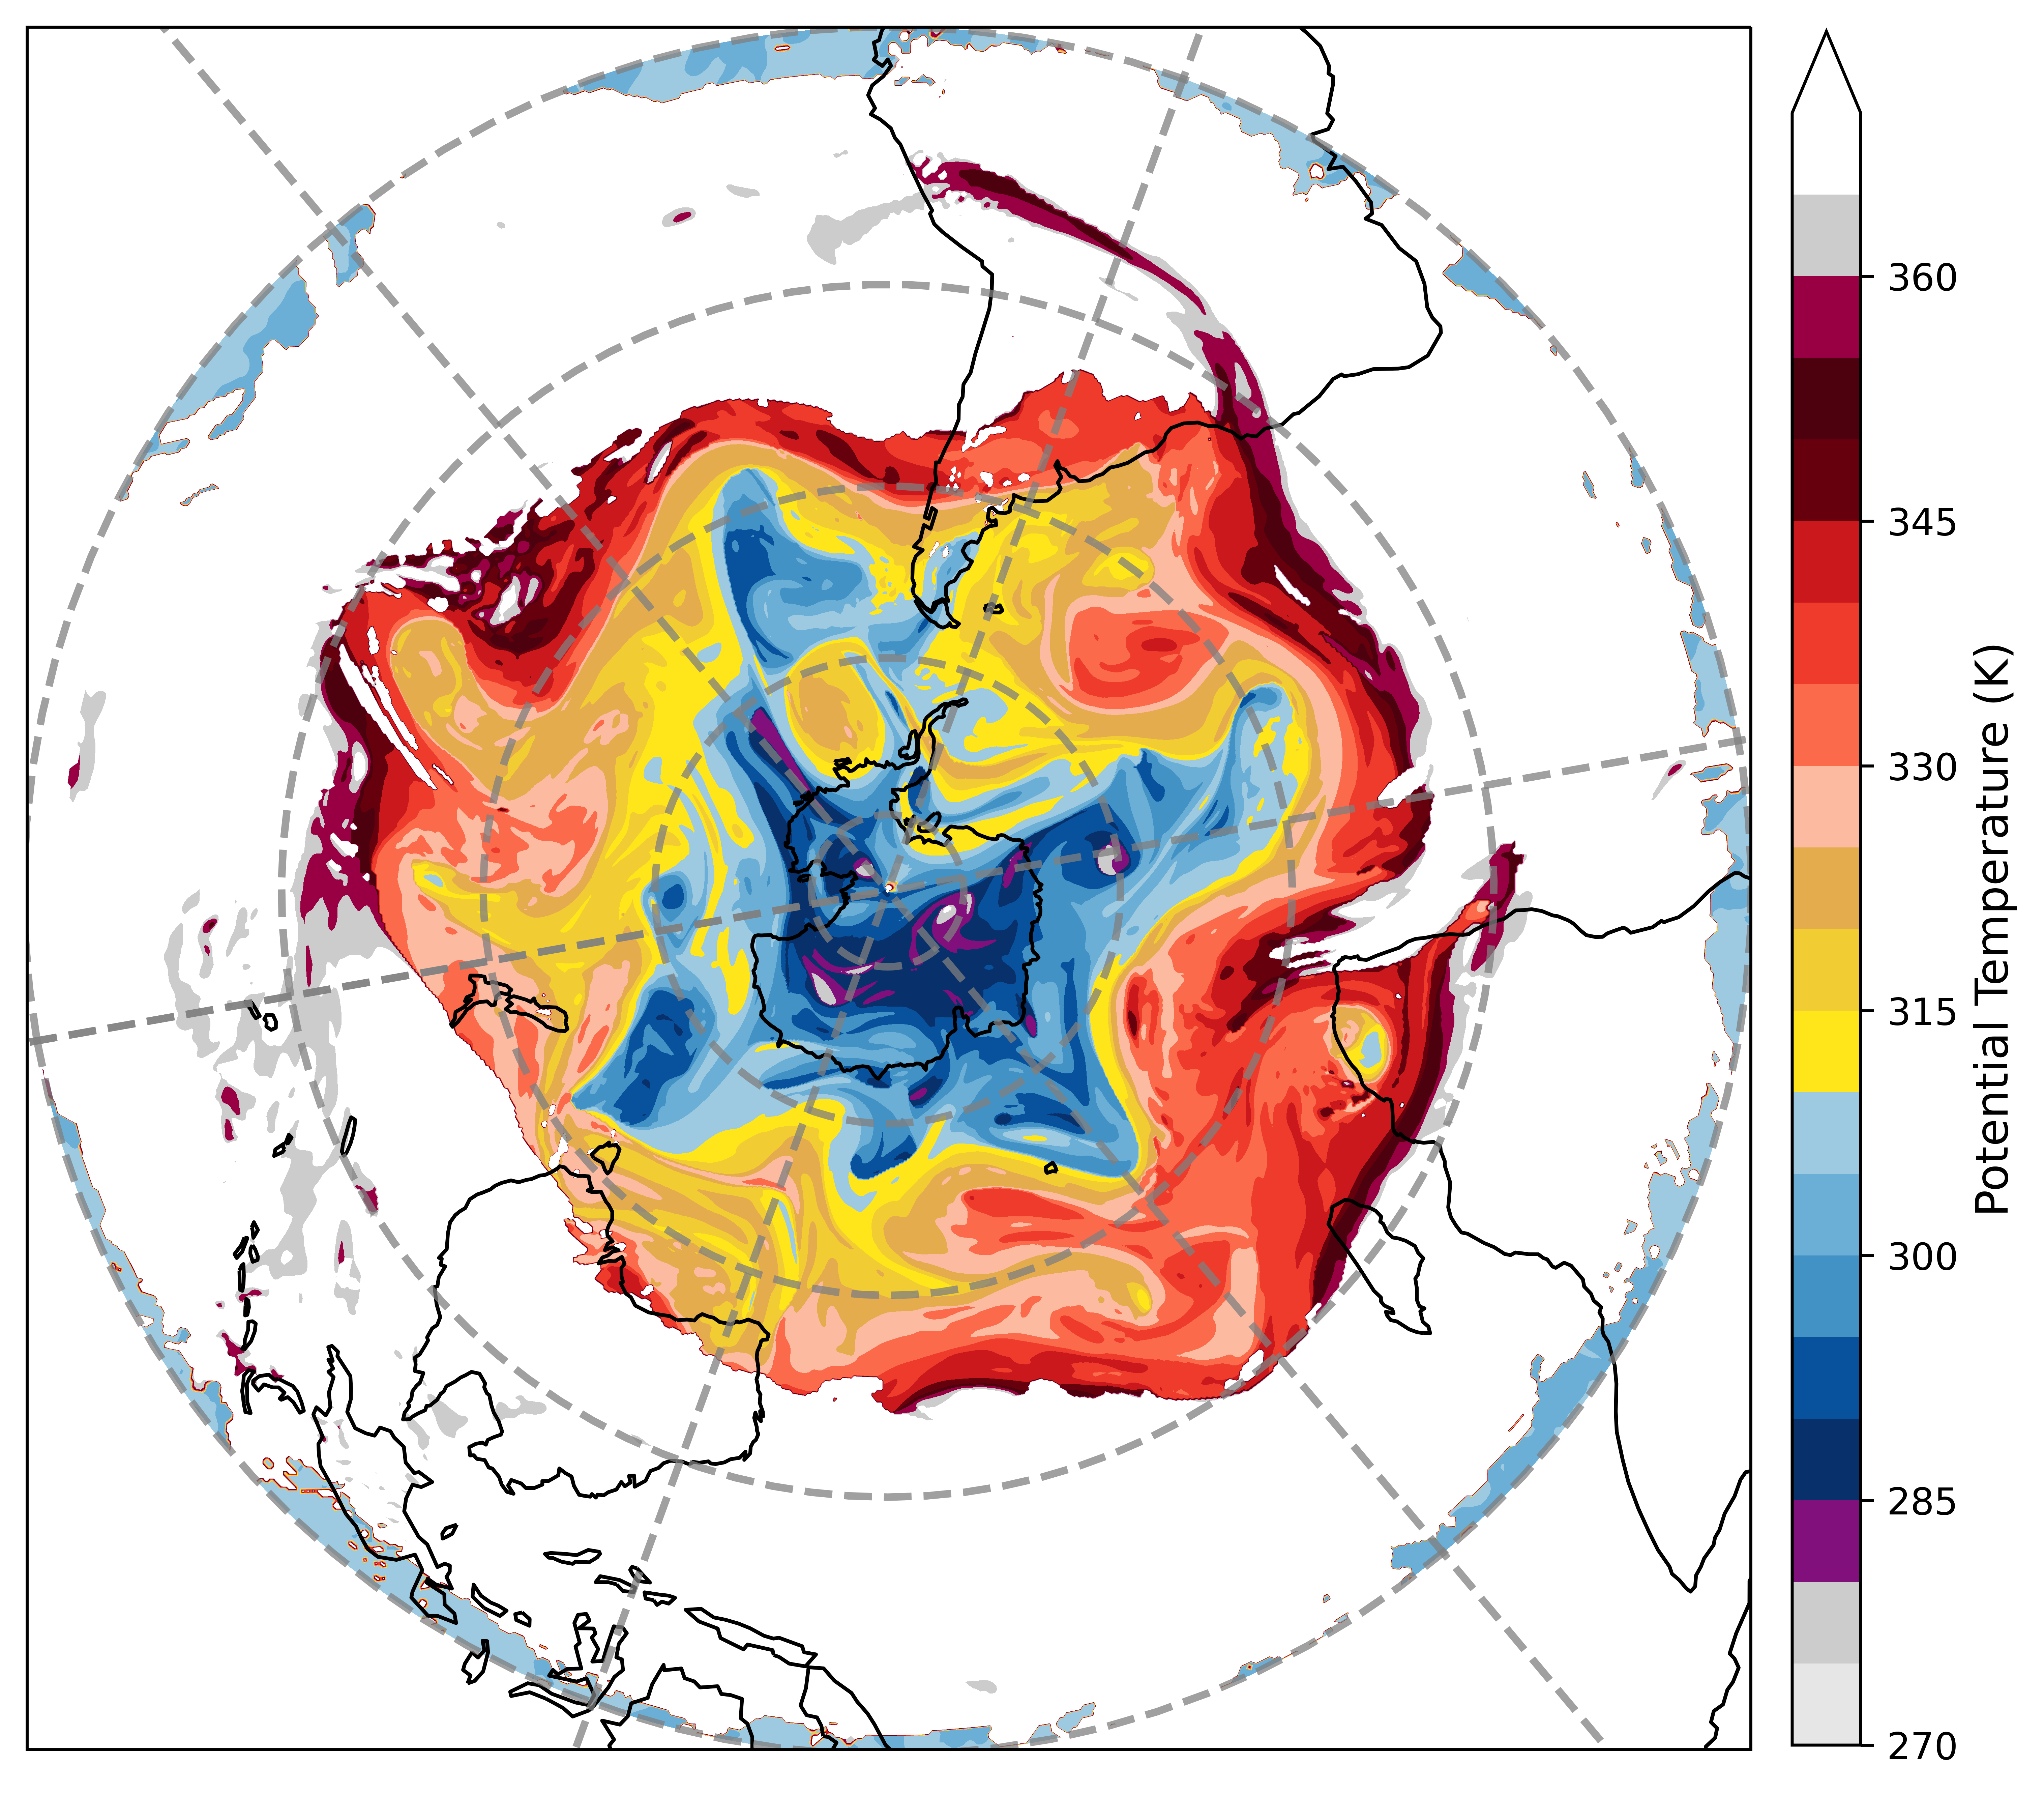

In [26]:
ct_int = np.arange(270,371,5)
plot_var = DT_theta[0] # Plot one time step

fig, ax = plt.subplots(1,1,dpi=800,figsize=(8,8),subplot_kw={'projection':ccrs.SouthPolarStereo(central_longitude=-80)})

cyclic_var, cyclic_lons = cu.add_cyclic_point(plot_var, coord = lons)
cl = ax.contourf(cyclic_lons, lats_hsphr, cyclic_var,levels=ct_int,cmap = rwb.thetaCB(), transform = ccrs.PlateCarree(),extend='max')
ax.add_feature(cfeature.COASTLINE)
ax.set_extent([-180, 180, -90, 0],crs = ccrs.PlateCarree())

# ax.set_aspect('auto')
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels = True, linewidth = 2, color = 'grey',alpha = 0.75, linestyle = '--')
gl.y_inline = False
gl.bottom_labels = False
gl.left_labels = False
gl.right_labels = False
gl.top_labels = False
gl.xlines = True
gl.ylines = True 
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'color': 'black', 'weight':'bold','rotation':45, 'fontsize':8}
gl.ylabel_style = {'color': 'black', 'weight':'bold','rotation':45}

fig.canvas.draw()
fig.tight_layout(w_pad = 0.5)
cb = fig.colorbar(cl, ax = ax, orientation = 'vertical', aspect = 25, pad = 0.02,shrink = 0.825)
cb.set_label("Potential Temperature (K)", fontsize = 12)